<a href="https://colab.research.google.com/github/saisuryakeshetty/Spam_Filtering/blob/main/Spam_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Get the Data

In [ ]:
messages = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis

In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's make a new column to detect how long the text messages are:

In [ ]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Let's see if message length is a distinguishing feature between ham and spam

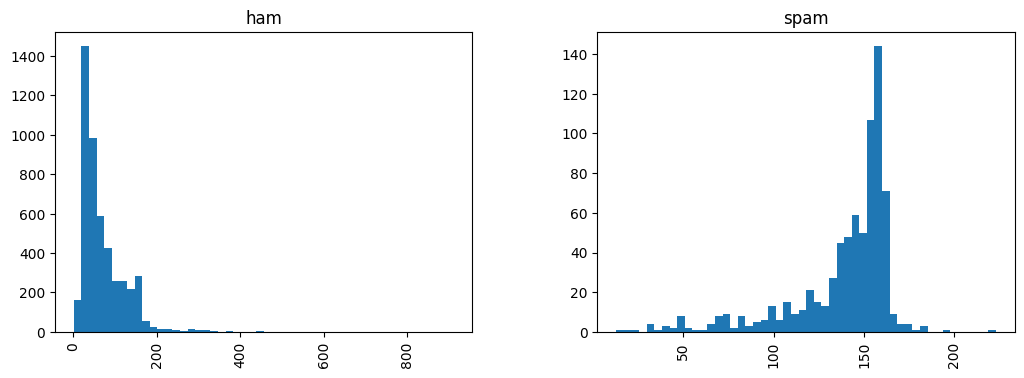

In [ ]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))
plt.show()

Looks like spam messages tend to have more characters.

# Text Pre-processing and Vectorization

Our main issue with our data is that it is all in text format (strings). The classification algorithm that we will be using need some sort of numerical feature vector in order to perform the classification task. There are actually many technique to convert a corpus to a vector format like Bag of Words, TF-IDF, Word2Vec...etc.

First, let's write a function that will split a message into its individual words and return a list. We'll remove punctuations and very common words, ('the', 'a', etc..). We will use NLTK library to get very common words and Python's built-in **string** library to get a quick list of all the possible punctuation.

In [ ]:
from nltk.corpus import stopwords
# Show list of stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# show string of punctuations
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [ ]:
# show orginal DataFrame
messages['message'].head(5)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [ ]:
# Check to make sure function is working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [ ]:
#splitting the data
msg = messages['message']
label = messages['label']
msg_train, msg_test, label_train, label_test = train_test_split(msg, label, test_size=0.2,stratify = label) # 'stratify = label' helps in keeping proportions of spam and ham same in train,test datasets

We'll convert the raw messages (sequence of characters) into vectors (sequences of numbers) using TfidfVectorizer.

This technique includes

1) Counting how many times does a word occur in each message (Known as term frequency(TF))

2) Weighing the counts, so that frequent words get lower weight (known as inverse document frequency(IDF))

3) Normalising the vectors to unit length

There are a lot of arguments and parameters that can be passed to the TfidfVectorizer. In this case we will just specify the analyzer to be our own previously defined function.

In [ ]:
Vectorizer = TfidfVectorizer(analyzer=text_process)
msg_train=Vectorizer.fit_transform(msg_train) # vectorising train data

In [ ]:
msg_test=Vectorizer.transform(msg_test) # vectorising test data

# Training a model

The Naive Bayes classifier algorithm is a good choice for spam classifier.

In [ ]:
model = MultinomialNB()
model.fit(msg_train, label_train)

MultinomialNB()

# Model Evaluation

In [ ]:
predictions = model.predict(msg_test)

In [ ]:
print('accuracy of model: ',accuracy_score(label_test,predictions))

accuracy of model:  0.968609865470852


In [ ]:
print(classification_report(label_test,predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
cm = confusion_matrix(label_test,predictions)

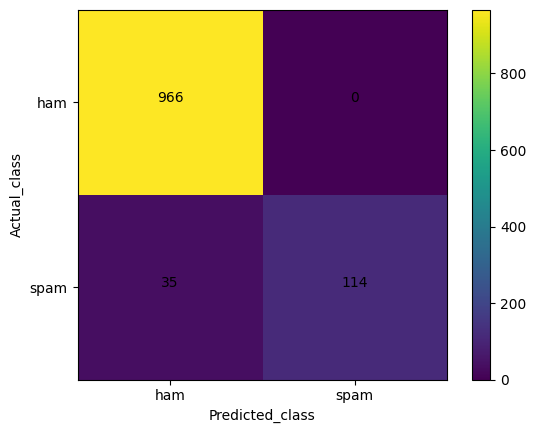

In [ ]:
plt.imshow(cm)
plt.colorbar()
plt.xticks([0,1],['ham','spam'])
plt.yticks([0,1],['ham','spam'])
for i in range(2):
  for j in range(2):
    plt.text(j,i,cm[i,j],horizontalalignment="center")
plt.xlabel('Predicted_class')
plt.ylabel('Actual_class')
plt.show()

In spam classifiers it is acceptable to some extent to miss out on a spam text being detected, but any ham/legitimate text should not be predicted as spam. Here number of such cases is 0 (i.e. spam precision = 1) and also out model has good f1_score.